In [876]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from statsmodels import tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import json


# Analysis

In [877]:
movie_directors = pd.read_csv('data/processed/movies_director.csv')

In [878]:
movie_directors.head()

,wikipedia_movie_id,Director,Gender
0,975900,John Carpenter,M
1,9363483,Donald Cammell,M
2,261236,Robert van Ackeren,M
3,10408933,Henry King,M
4,175026,Dorothy Arzner,F


In [879]:
# distribution of genders amongst movie directors
fig = px.histogram(movie_directors, x='Gender', title='Gender distribution of movies director')
fig.show()

# Analysis with characters

## Splitting the movie ids: male / female real

In [880]:
movie_directors["wikipedia_movie_id"] = movie_directors["wikipedia_movie_id"].apply(lambda x: str(x))
movies_M = movie_directors[movie_directors["Gender"].apply(lambda x: x=="M")]
movies_F = movie_directors[movie_directors["Gender"].apply(lambda x: x=="F")]

## Actors age

In [881]:
# load characters metadata
char_metadata_df = pd.read_csv("data/processed/characters_metadata.csv")
char_metadata_df["wikipedia_movie_id"] = char_metadata_df["wikipedia_movie_id"].apply(lambda x: str(x))

Splitting the char_metadata_df between the gender of the realisator. First, removing duplicates on actor_names to get actor data and not character.
Check for duplicates: char_metadata_df.where(char_metadata_df.duplicated(subset=["wikipedia_movie_id", "actor_name"]) == True).value_counts()

In [882]:
actors_age = char_metadata_df.copy(deep=True)
actors_age = actors_age.drop_duplicates(subset=["wikipedia_movie_id", "actor_name"])
actors_age["actor_gender_binary"] = actors_age["actor_gender"].apply(lambda x: 0 if x == "M" else 1)

At this step, we complete the age missing values by computing the difference between date of birth and release date.

In [883]:
def to_datetime(df, column):
    # filtering of data for panda.dataframe compliances
    df[column] = df[column].astype(str)

    df = df[(
    df[column] > '1850-01-01') & (df[column] < '2022-01-01'
    )]
    # handling the nan case
    df[column] = df[column].fillna('1850-01-01')
    # keeping only year
    df[column] = pd.to_datetime(df[column], errors="coerce") # need to remove format="mixed" so it works!

    # df = df[df[column].notna()]
    df[column] = df[column].dt.year
    # converting to int
    df[column] = df[column].apply(lambda x: int(x) if pd.notna(x) else x)

    return df

In [884]:
actors_age = to_datetime(actors_age, "actor_date_of_birth")
actors_age.loc[actors_age["actor_age"].isna(), "actor_age"] = (
    (actors_age["movie_release_date"] - actors_age["actor_date_of_birth"])
)

In [885]:
actors_age_M = actors_age[actors_age["wikipedia_movie_id"].isin(movies_M["wikipedia_movie_id"])].reset_index(drop=True)
actors_age_F = actors_age[actors_age["wikipedia_movie_id"].isin(movies_F["wikipedia_movie_id"])].reset_index(drop=True)

In [886]:
def plot_age_distribution(actors_age, gender_real:str):

    actors_age_gender = actors_age.groupby("actor_age")["actor_gender_binary"].value_counts().unstack(fill_value=0).reset_index()
    actors_age_gender["Tot_actors"] = actors_age_gender[0] + actors_age_gender[1]
    actors_age_gender = actors_age_gender[actors_age_gender["Tot_actors"] >= 200]

    # Calculate weighted average age for each gender
    avg_age_male = (actors_age_gender['actor_age'] * actors_age_gender[0]).sum() / actors_age_gender[0].sum()
    avg_age_female = (actors_age_gender['actor_age'] * actors_age_gender[1]).sum() / actors_age_gender[1].sum()

    male_trace = go.Scatter(
        x=actors_age_gender['actor_age'],
        y=actors_age_gender[0],
        mode="lines+markers",
        name="Male actors",
        line=dict()
    )
    female_trace = go.Scatter(
        x=actors_age_gender['actor_age'],
        y=actors_age_gender[1],
        mode="lines+markers",
        name="Female actors",
        line=dict()
    )


    # Create traces for the average age lines
    avg_male_line = go.Scatter(
        x=[avg_age_male, avg_age_male],
        y=[0, actors_age_gender[[0, 1]].values.max()],
        mode="lines",
        line=dict(color="red", dash="dash"),
        name=f"Avg Male Age: {avg_age_male:.0f}"
    )
    avg_female_line = go.Scatter(
        x=[avg_age_female, avg_age_female],
        y=[0, actors_age_gender[[0, 1]].values.max()],
        mode="lines",
        line=dict(color="red"),
        name=f"Avg Female Age: {avg_age_female:.0f}"
    )

    # Create the figure
    fig = go.Figure(data=[male_trace, female_trace, avg_male_line, avg_female_line])

    # Update layout
    fig.update_layout(
        title=f"Number of Characters by Age - {gender_real} Filmmaker",
        xaxis_title="Age",
        yaxis_title="Number of Actors",
        barmode="stack",
        legend_title="Legend",
        template="plotly_white"
    )


    # Show the plot
    fig.show()


In [887]:
plot_age_distribution(actors_age_M, "Male")

In [888]:
plot_age_distribution(actors_age_F, "Female")

**Discussion:** Do a percentage, both on the same

## Number of actors distribution

In [889]:
# First, filter and start years in 1930
actors_age_M = actors_age_M[actors_age_M["movie_release_date"] >= 1930]
actors_age_F = actors_age_F[actors_age_F["movie_release_date"] >= 1930]

# Group by movie release date and calculate the mean proportion of female characters
characters_gender_time_M = actors_age_M.groupby("movie_release_date")["actor_gender_binary"].agg(['mean', 'count']).reset_index()
characters_gender_time_F = actors_age_F.groupby("movie_release_date")["actor_gender_binary"].agg(['mean', 'count']).reset_index()

# Total number of movies
num_movies_M = actors_age_M.groupby("movie_release_date")["wikipedia_movie_id"].nunique().values
num_movies_F = actors_age_F.groupby("movie_release_date")["wikipedia_movie_id"].nunique().values

# Create the plot with Plotly
fig = go.Figure()

# Female representation for male-directed movies
fig.add_trace(go.Scatter(
    x=characters_gender_time_M["movie_release_date"],
    y=np.array(characters_gender_time_M["mean"]) * 100,  # Convert to percentage
    name="Male Directors",
    mode="lines",
    customdata=np.stack((characters_gender_time_M['count'], num_movies_M), axis=-1),
    hovertemplate=(
        "Year: %{x}<br>"
        "Proportion of Female Characters: %{y:.2f}<br><br>"
        "Total Number of Characters: %{customdata[0]}<br>"
        "Number of Movies: %{customdata[1]}"
    ),
))

# Female representation for female-directed movies
fig.add_trace(go.Scatter(
    x=characters_gender_time_F["movie_release_date"],
    y=np.array(characters_gender_time_F["mean"]) * 100,  # Convert to percentage
    name="Female Directors",
    mode="lines",
    customdata=np.stack((characters_gender_time_F['count'], num_movies_F), axis=-1),
    hovertemplate=(
        "Year: %{x}<br>"
        "Proportion of Female Characters: %{y:.2f}<br><br>"
        "Total Number of Characters: %{customdata[0]}<br>"
        "Number of Movies: %{customdata[1]}"
    ),
))

# Customize the layout
fig.update_layout(
    title="Representation of Female Characters by Director Gender",
    yaxis_title="Percentage of Female Characters in Movies [%]",
    xaxis=dict(
        tickmode='array',
        tickvals=characters_gender_time_M["movie_release_date"][::5],  # Display ticks every 5 years
        ticktext=characters_gender_time_M["movie_release_date"][::5]
    ),
    yaxis=dict(
        tickformat=".0f",  # This formats the y-axis ticks as whole percentages
    ),
    legend_title="Director Gender",
    width=1150,
    height=700,
    template="plotly_white"  # Use a white background
)

fig.show()


## Characters and movie metadata

In [890]:
movies_metadata_df = pd.read_csv("data/processed/movies_metadata.csv")
movies_metadata_df["wikipedia_movie_id"] = movies_metadata_df["wikipedia_movie_id"].apply(lambda x: str(x))

In [891]:
import ast

movies_df = movies_metadata_df.copy(deep=True)
# only interesting columns
movies_df = movies_df[["wikipedia_movie_id", "movie_release_date", "movie_genres", "movie_countries"]]
# groupby to make a list that contains all genders for a given movie
genders_grouped = (
    char_metadata_df.groupby("wikipedia_movie_id")["actor_gender"]
    .apply(list)  # Collect genders into lists
    .reset_index()  # Reset index to make it a DataFrame
    .rename(columns={"actor_gender": "actor_genders"})  # Rename the column
)
# merging
movies_df = movies_df.merge(genders_grouped, on="wikipedia_movie_id", how="left")
movies_df['movie_genres'] = movies_df['movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
movies_df['movie_countries'] = movies_df['movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

movies_df


,wikipedia_movie_id,movie_release_date,movie_genres,movie_countries,actor_genders
0,3196793,2000,"[Horror, Biographical and Real-Life Inspired, ...",[United States],"[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]"
1,28463795,1988,"[Crime and Mystery, Drama]",[Norway],"[M, F, M, F]"
2,9363483,1987,"[Thriller, Erotic and Adult Films]",[United Kingdom],"[M, F]"
3,261236,1983,[Drama],[Germany],"[F, M, M]"
4,18998739,2002,"[Family's Films, Fantasy, Adventure, World Cin...",[South Africa],"[M, F, M, M, M, M, M, M]"
...,...,...,...,...,...
73865,35228177,2011,[Drama],[United States],NaN
73866,34980460,2011,"[Biographical and Real-Life Inspired, Drama, D...","[Ireland, United Kingdom]",NaN
73867,9971909,1972,[Comedy],[United States],"[M, M]"
73868,913762,1992,"[Science Fiction, Asian Cinema, Adventure, Ani...",[Japan],"[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]"


In [892]:
import plotly.graph_objects as go

def plot_top10_genres(movies_df, gender_real):
    genre_gender_counts = movies_df.explode("actor_genders").explode("movie_genres")
    gender_genre_counts = genre_gender_counts.groupby(['movie_genres', 'actor_genders']).size().unstack(fill_value=0)
    gender_genre_percentages = gender_genre_counts.div(gender_genre_counts.sum(axis=1), axis=0) * 100
    genre_counts = genre_gender_counts.groupby('movie_genres').size().sort_values(ascending=False).head(10)
    gender_genre_counts_top10 = gender_genre_counts.loc[genre_counts.index]
    gender_genre_percentages_top10 = gender_genre_percentages.loc[genre_counts.index]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=gender_genre_percentages_top10.index,
        y=gender_genre_percentages_top10['F'],
        name="Female",
        marker_color="#EF553B",
    ))
    fig.add_trace(go.Bar(
        x=gender_genre_percentages_top10.index,
        y=gender_genre_percentages_top10['M'],
        name="Male",
        marker_color="#636EFA"
    ))

    fig.update_layout(
        title=f"Gender Representation Across Top-10 Movie Genres - {gender_real} Filmmaker",
        xaxis_title="Movie Genre",
        yaxis_title="Percentage of Characters (%)",
        barmode='stack',
        xaxis=dict(
            tickmode='array',
            tickvals=gender_genre_percentages_top10.index,
            ticktext=gender_genre_percentages_top10.index,
            tickangle=45
        ),
        height=600,
        legend_title="Gender",
        legend=dict(title="Gender", orientation="h", x=0.5, xanchor="center", y=1.1)
    )
    fig.show()

import plotly.graph_objects as go


In [893]:
movies_genres_M = movies_df[movies_df["wikipedia_movie_id"].isin(movies_M["wikipedia_movie_id"])]
movies_genres_F = movies_df[movies_df["wikipedia_movie_id"].isin(movies_F["wikipedia_movie_id"])]

In [894]:
plot_top10_genres(movies_genres_M, "Male")
plot_top10_genres(movies_genres_F, "Female")

**Discussion:** Add the total number of movies

In [899]:
def plot_top15_genres(movies_df, gender_real):
    # Explode the DataFrame to get one row per genre and gender
    genre_gender_counts = movies_df.explode("actor_genders").explode("movie_genres")
    
    # Count the number of movies per genre
    genre_movie_counts = genre_gender_counts.groupby("movie_genres").size()

    # Count occurrences of each genre
    genre_counts = movies_genres_M.explode("movie_genres")["movie_genres"].value_counts()
    # Calculate percentages
    genre_movie_percentages = (genre_counts / genre_counts.sum()) * 100
    
    # Filter to include only genres with at least 50 movies
    valid_genres = genre_percentages[genre_percentages >= 0.05].index
    genre_gender_counts = genre_gender_counts[genre_gender_counts["movie_genres"].isin(valid_genres)]
    
    # Calculate the gender counts and percentages for the filtered genres
    gender_genre_counts = genre_gender_counts.groupby(['movie_genres', 'actor_genders']).size().unstack(fill_value=0)
    gender_genre_percentages = gender_genre_counts.div(gender_genre_counts.sum(axis=1), axis=0) * 100
    
    # Sort and take the top 15 genres by percentage of female characters
    top_15_genres_female_percentage = gender_genre_percentages["F"].sort_values(ascending=False).head(10)
    
    # Get the corresponding number of movies and percentages for these genres
    top_15_genres_movie_counts = genre_movie_counts[top_15_genres_female_percentage.index]
    top_15_genres_movie_percentages = genre_movie_percentages[top_15_genres_female_percentage.index]
    top_15_genres_female_characters = gender_genre_counts.loc[top_15_genres_female_percentage.index, "F"]
    
    # Plot the data
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=top_15_genres_female_percentage.index,
        y=top_15_genres_female_percentage,
        name="Female",
        marker_color="#EF553B",
        textposition='auto'  # Display the text directly on the bars
    ))
    
    # Update the layout
    fig.update_layout(
        title=f"Top-15 Genres with Highest Percentage of Female Characters - {gender_real} Director",
        xaxis_title="Movie Genre",
        yaxis_title="Percentage of Female Characters (%)",
        xaxis=dict(
            tickmode='array',
            tickvals=top_15_genres_female_percentage.index,
            ticktext=top_15_genres_female_percentage.index,
            tickangle=45
        ),
        height=600
    )
    
    # Add hover details
    fig.update_traces(
        customdata=np.stack((top_15_genres_female_characters.values, 
                             top_15_genres_movie_counts.values, 
                             top_15_genres_movie_percentages.values), axis=-1),
        hovertemplate=(
            "Genre: %{x}<br>"
            "Proportion of Female Characters: %{y:.2f}%<br>"
            "Total Female Characters: %{customdata[0]}<br>"
            "Number of Movies: %{customdata[1]}<br>"
            "Percentage of Movies in Genre: %{customdata[2]:.2f}%"
        )
    )
    
    fig.show()


In [900]:
plot_top15_genres(movies_genres_M, "Male")
plot_top15_genres(movies_genres_F, "Female")

### Display the genres by percentage

In [828]:
# Explode genres


# Count occurrences of each genre
genre_counts = movies_genres_M.explode("movie_genres")["movie_genres"].value_counts()

# Calculate percentages
genre_percentages = (genre_counts / genre_counts.sum()) * 100
genre_percentages[genre_percentages > 0.5].index



Index(['Drama', 'Comedy', 'World Cinema', 'Adventure', 'Thriller', 'Romance',
       'Action', 'Horror', 'Black-and-white', 'Crime and Mystery',
       'Music and Dance', 'Family's Films', 'Science Fiction', 'Short Film',
       'Biographical and Real-Life Inspired', 'Silent film', 'Fantasy',
       'War and Military', 'Western', 'Documentary', 'Reboot', 'Animation',
       'Independent', 'Children's Films', 'Television movie', 'LGBT',
       'Historical Films'],
      dtype='object', name='movie_genres')

# Race chart of genres

should change movies_M and movies_F to get both

In [789]:
# Step 1: Filter movies for male directors
movies_genres_M = movies_df[movies_df["wikipedia_movie_id"].isin(movies_F["wikipedia_movie_id"])][["wikipedia_movie_id", "movie_release_date", "movie_genres"]]

# Step 2: Consider movies released from 1930 onward
movies_genres_M = movies_genres_M[movies_genres_M["movie_release_date"] >= 1930]

# Step 3: Explode the 'movie_genres' column to create one row per genre
movies_genres_M = movies_genres_M.explode("movie_genres")

# Step 4: Count the total occurrences of each genre across all years
global_genre_counts = movies_genres_M['movie_genres'].value_counts()

# Step 5: Identify the global top-8 genres
global_top_8_genres = global_genre_counts.head(8).index.tolist()

# Step 6: Filter the dataset to include only the global top-8 genres
movies_genres_top_8 = movies_genres_M[movies_genres_M["movie_genres"].isin(global_top_8_genres)]

# Step 7: Group by year and genre, count the occurrences
movies_genres_top_8_year = movies_genres_top_8.groupby(['movie_release_date', 'movie_genres']).size().reset_index(name='count')

# Step 8: Add the rank for each genre within each year
movies_genres_top_8_year['rank'] = (
    movies_genres_top_8_year.groupby('movie_release_date')['count']
    .rank(ascending=False, method='first')  # Resolve ties by order of appearance
    .astype(int) - 1  # Convert ranks to 0-based
)

# # Step 9: Normalize rankings to ensure they are 0 to 7
# movies_genres_top_8_year['rank'] = (
#     movies_genres_top_8_year.groupby('movie_release_date')['rank']
#     .transform(lambda x: pd.Series(range(len(x))))
# )

# Step 10: Sort by year and rank
movies_genres_top_8_year = movies_genres_top_8_year.sort_values(['movie_release_date', 'rank']).reset_index(drop=True)

# Display the resulting DataFrame
movies_genres_top_8_year


,movie_release_date,movie_genres,count,rank
0,1930,Drama,5,0
1,1930,Comedy,3,1
2,1930,Horror,2,2
3,1930,Romance,2,3
4,1930,Action,1,4
...,...,...,...,...
617,2012,Romance,11,3
618,2012,Action,8,4
619,2012,Horror,8,5
620,2012,World Cinema,3,6


In [790]:
import json

# Format the data as specified
formatted_data = movies_genres_top_8_year.groupby('movie_release_date').apply(
    lambda group: [
        {
            "name": row["movie_genres"],
            "value": row["count"],
            "rank": row["rank"]
        } for _, row in group.iterrows()
    ]
).reset_index(name="genres").apply(
    lambda row: [row['movie_release_date'], row['genres']], axis=1
).tolist()

# Save the formatted data to a JSON file
output_path = "top_genres_by_year_F.json"
with open(output_path, "w") as f:
    json.dump(formatted_data, f, indent=4)

output_path


'top_genres_by_year_F.json'

In [768]:
print(movies_genres_top_8.columns)


Index(['wikipedia_movie_id', 'movie_release_date', 'movie_genres'], dtype='object')


# Keep going for the race chart! --> female !

# Bubble charts of genres with female characters

# By countries

In [772]:
import plotly.graph_objects as go

def plot_genre_country_gender_representation(movies_genres_country_df, gender_real=""):
    genre_country_gender_counts = movies_genres_country_df.explode("actor_genders").explode("movie_genres").explode("movie_countries")

    genre_country_gender_counts = genre_country_gender_counts.groupby(['movie_genres', 'movie_countries', 'actor_genders']).size().unstack(fill_value=0)

    gender_percentage = genre_country_gender_counts['F'] / genre_country_gender_counts.sum(axis=1) * 100

    total_actors = genre_country_gender_counts.sum(axis=1)

    countries = sorted(genre_country_gender_counts.groupby('movie_countries').size().sort_values(ascending=False).head(10).index)
    
    gender_percentage_top_10_countries = gender_percentage[gender_percentage.index.get_level_values('movie_countries').isin(countries)]
    gender_percentage_top_10_countries = gender_percentage_top_10_countries[gender_percentage_top_10_countries >= 40]

    genre_country_gender_counts_top_10_countries = genre_country_gender_counts.loc[gender_percentage_top_10_countries.index]

    bubble_size = total_actors.loc[gender_percentage_top_10_countries.index] * 0.1  # Adjust this factor to reduce bubble size

    # Ensure the bubble sizes are within a reasonable range
    max_bubble_size = bubble_size.max()
    min_bubble_size = bubble_size.min()
    bubble_size = (bubble_size - min_bubble_size) / (max_bubble_size - min_bubble_size) * 150  # Scale the bubble size to a max value of 40

    genres = sorted(genre_country_gender_counts.index.get_level_values('movie_genres').unique())

    genre_indices = [genres.index(genre) for genre in gender_percentage_top_10_countries.index.get_level_values('movie_genres')]
    country_indices = [countries.index(country) for country in gender_percentage_top_10_countries.index.get_level_values('movie_countries')]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=genre_indices,
        y=country_indices,
        mode='markers',
        marker=dict(
            size=bubble_size,
            color=gender_percentage.loc[gender_percentage_top_10_countries.index],
            # colorscale='PuRd',
            showscale=True,
            opacity=0.6,
            line=dict(width=1, color='white')
        ),
        text=gender_percentage_top_10_countries.index.get_level_values('movie_genres') + " - " + gender_percentage_top_10_countries.index.get_level_values('movie_countries'),
        hovertemplate='%{text}<br>Female Percentage: %{marker.color:.2f}%<br>Total Actors: %{marker.size}<extra></extra>'
    ))

    fig.update_layout(
        title=f"Gender Representation Across Movie Genres and Top-10 Countries - {gender_real} Filmmaker",
        xaxis_title="Movie Genre",
        yaxis_title="Country",
        xaxis=dict(
            tickvals=list(range(len(genres))),
            ticktext=genres,
            tickangle=45
        ),
        yaxis=dict(
            tickvals=list(range(len(countries))),
            ticktext=countries
        ),
        showlegend=False,
        height=600
    )

    fig.show()


In [773]:
plot_genre_country_gender_representation(movies_genres_M, "Male")

KeyError: 'movie_countries'

In [ ]:
plot_genre_country_gender_representation(movies_genres_F, "Female")

**Discussion:** Reduce scale on the right, create a map

## With TV tropes

In [774]:
from src.data.data_loader import load_csv
tvtropes_df = load_csv('data/raw/' + 'tvtropes.clusters.txt', has_column_names=False, is_tsv=True, column_names=['character_type', 'metadata'])

Loaded data from data/raw/tvtropes.clusters.txt, shape: (500, 2)


In [775]:
tvtropes_df['metadata'] = tvtropes_df['metadata'].apply(ast.literal_eval)
tvtropes_df = pd.concat([tvtropes_df.drop(['metadata'], axis=1), tvtropes_df['metadata'].apply(pd.Series)], axis=1)
tvtropes_df = tvtropes_df.rename(columns={'char': 'char_name', 'actor': 'actor_name', 'movie': 'movie_name', 'id': 'char_actor_id'})
# We add the character information and especially its gender
tvtropes_df['actor_gender'] = tvtropes_df['actor_name'].map(char_metadata_df.set_index('actor_name')['actor_gender'].to_dict())

tvtropes_df.head()

,character_type,char_name,movie_name,char_actor_id,actor_name,actor_gender
0,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M
1,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M
2,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M
3,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M
4,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,M


In [776]:
# Complete tvtropes to get the movie ID, using the name of the movie and the char_actor_id, to get movie genres and countries
# we first need to add the movie_name column in the char_metadata_df
char_movie_df = pd.merge(
    actors_age,
    movies_df[['wikipedia_movie_id', "movie_countries", "movie_genres"]],  # Only need char_id and wikipedia_movie_id
    how='left',  # Use left join to keep all rows from tv_tropes_df
    on=['wikipedia_movie_id']  # Merge on char_id and movie_name
)
# now we can complete tvtropes
tvtropes_completed_df = pd.merge(
    tvtropes_df,
    char_movie_df[['char_actor_id', 'wikipedia_movie_id', "movie_countries", "movie_genres", "movie_release_date"]],  # Only need char_id and wikipedia_movie_id
    how='left',  # Use left join to keep all rows from tv_tropes_df
    on=['char_actor_id']  # Merge on char_id and movie_name
)

In [777]:
import plotly.graph_objects as go

def plot_gender_tvtropes(tvtropes_completed_df, gender_real):
    # Group by character type and actor gender
    character_type_gender_counts = tvtropes_completed_df.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)
    filtered_character_type_gender_counts = character_type_gender_counts[character_type_gender_counts['F'] > 0]

    # Create the plot with Plotly
    fig = go.Figure()

    # Plot Female data (stacked bar)
    fig.add_trace(go.Bar(
        x=filtered_character_type_gender_counts.index,
        y=filtered_character_type_gender_counts['F'],
        name='Female',
        marker_color="rgba(255, 99, 132, 0.7)",  # Soft red
        text=filtered_character_type_gender_counts['F'],
        hovertemplate='Character Type: %{x}<br>Female Actors: %{y}<extra></extra>',
    ))

    # Plot Male data (stacked bar)
    fig.add_trace(go.Bar(
        x=filtered_character_type_gender_counts.index,
        y=filtered_character_type_gender_counts['M'],
        name='Male',
        marker_color="rgba(54, 162, 235, 0.7)",  # Soft blue
        text=filtered_character_type_gender_counts['M'],
        hovertemplate='Character Type: %{x}<br>Male Actors: %{y}<extra></extra>',
    ))

    # Update layout for overall aesthetics
    fig.update_layout(
        title=f"Gender Representation Across Character Types - {gender_real} Filmmaker",
        xaxis_title="Character Type",
        yaxis_title="Number of Actors",
        barmode='stack',  # Stack the bars for gender representation
        showlegend=True,
        height=600,  # Adjust the plot height for better readability
        xaxis=dict(
            tickangle=45,  # Rotate tick labels to make them readable
            tickfont=dict(size=10),  # Adjust font size of x-ticks
            tickmode='array',
            tickvals=filtered_character_type_gender_counts.index,
            ticktext=filtered_character_type_gender_counts.index,
        ),
        yaxis=dict(
            title="Number of Actors",
            tickfont=dict(size=12),  # Adjust font size of y-ticks
        ),
        legend_title="Gender",
        legend=dict(
            orientation="v",  # Vertical legend for space efficiency
            yanchor="top", 
            y=1,  # Position at the top of the plot
            xanchor="right", 
            x=1,  # Align to the right
        ),
        margin=dict(t=50, b=100, l=50, r=50),  # Adjust margins for better spacing
        template="plotly_white"  # Use white background for the plot
    )

    fig.show()


In [778]:
tvtropes_M = tvtropes_completed_df[tvtropes_completed_df["wikipedia_movie_id"].isin(movies_M["wikipedia_movie_id"])]
tvtropes_F = tvtropes_completed_df[tvtropes_completed_df["wikipedia_movie_id"].isin(movies_F["wikipedia_movie_id"])]

In [779]:
plot_gender_tvtropes(tvtropes_M, "Male")

In [780]:
plot_gender_tvtropes(tvtropes_F, "Female")

**Discussion:** Go check the tv-tropes.

# Bechdel Test

In [507]:
bechdel_df = pd.read_csv('data/processed/bechdel_ratings.csv')
bechdel_df["wikipedia_movie_id"] = bechdel_df["wikipedia_movie_id"].apply(lambda x: str(x))

### Data augmentation

In [509]:
bechdel_df = pd.merge(
    bechdel_df,
    movies_df[['wikipedia_movie_id', "movie_genres", "movie_countries", "actor_genders"]],
    how = "inner", # first line is dropped
    on = "wikipedia_movie_id"
)

### Differentiating between directors

In [510]:
bechdel_M = bechdel_df[bechdel_df['wikipedia_movie_id'].isin(movies_M['wikipedia_movie_id'])]
bechdel_F = bechdel_df[bechdel_df['wikipedia_movie_id'].isin(movies_F['wikipedia_movie_id'])]

In [511]:
bechdel_M.shape, bechdel_F.shape

((3268, 7), (365, 7))

In [704]:
# Data
bechdel_M_hist = (bechdel_M["bechdel_rating"].value_counts() / bechdel_M.shape[0] * 100).values
bechdel_F_hist = (bechdel_F["bechdel_rating"].value_counts() / bechdel_F.shape[0] * 100).values
x = np.array(bechdel_M["bechdel_rating"].value_counts().index)

# Create bar traces for Male and Female Directors
trace_male = go.Bar(
    x=x - 0.2,  # Shift male bars left by 0.2
    y=bechdel_M_hist,
    name='Male Directors',
    marker=dict(color='blue'),
    width=0.4
)

trace_female = go.Bar(
    x=x + 0.2,  # Shift female bars right by 0.2
    y=bechdel_F_hist,
    name='Female Directors',
    marker=dict(color='pink'),
    width=0.4
)

# Create layout
layout = go.Layout(
    title="Bechdel Test Ratings by Gender of Directors",
    xaxis=dict(title="Bechdel Rating", tickvals=x),
    yaxis=dict(title="Percentage (%)"),
    barmode='group',  # Group the bars
    bargap=0.2  # Gap between bars
)

# Create figure and show plot
fig = go.Figure(data=[trace_male, trace_female], layout=layout)
fig.show()


## Preprocessing data for ML

In [729]:
bechdel_ML = bechdel_df.copy(deep=True)

# adding director_gender column
bechdel_ML["director_gender"] = bechdel_ML["wikipedia_movie_id"].apply(
    lambda x: int(0) if x in movies_M['wikipedia_movie_id'].values else 
              (int(1) if x in movies_F['wikipedia_movie_id'].values else np.nan)
)
bechdel_ML = bechdel_ML.dropna(subset="director_gender")

In [730]:
# adding plot emotions
plot_emotion_df = pd.read_csv("data/processed/plot_emotions.csv")
plot_emotion_df["wikipedia_movie_id"] = plot_emotion_df["wikipedia_movie_id"].apply(lambda x: str(x))
# adding emotion col
bechdel_ML = pd.merge(
    bechdel_ML,
    plot_emotion_df[['wikipedia_movie_id', "plot_length_nb_words", "emotion_scores", "dominant_emotion"]],
    how = "inner", # first line is dropped
    on = "wikipedia_movie_id"
)
# handle emotions
# Replace single quotes with double quotes
bechdel_ML["emotion_scores"] = bechdel_ML["emotion_scores"].str.replace("'", '"')
# Parse the corrected strings into dictionaries
bechdel_ML["emotion_scores"] = bechdel_ML["emotion_scores"].apply(json.loads)

In [731]:
# take care of genres and countries and actor_genders columns
# get all genres and countries
genres_list = bechdel_ML.explode("movie_genres")["movie_genres"].unique().tolist()
countries_list = bechdel_ML.explode("movie_countries")["movie_countries"].unique().tolist()
emotion_list = bechdel_ML["dominant_emotion"].unique().tolist()
# add genre and countries columns
cols_df = pd.DataFrame(columns=["char_M", "char_F"] + genres_list + countries_list + emotion_list)
bechdel_ML = pd.concat([bechdel_ML, cols_df], axis=1).fillna(0).reset_index(drop=True)

for index, row in bechdel_ML.iterrows():
    genres = row["movie_genres"]
    countries = row["movie_countries"]
    genders = row["actor_genders"]
    emotions_dict = row["emotion_scores"]
    for genre in genres:
        bechdel_ML.at[index, genre] = 1
    for country in countries:
        bechdel_ML.at[index, country] = 1
    for gender in genders:
        if gender == "M":
            bechdel_ML.at[index, "char_M"] += 1
        else:
            bechdel_ML.at[index, "char_F"] += 1
    for emotion in emotion_list:
        bechdel_ML.at[index, emotion] = emotions_dict[emotion]

# making copy
bechdel_complete = bechdel_ML.copy(deep=True)
# dropping columns
bechdel_ML = bechdel_ML.drop(columns=["actor_genders", "movie_genres", "movie_countries", "actor_genders", "emotion_scores", "dominant_emotion", "wikipedia_movie_id", "movie_name"])
bechdel_ML.columns = bechdel_ML.columns.astype(str)

# simplifying the bechdel_rating column into 0 (fails test) and 1(passes test)
bechdel_ML["bechdel_rating"] = bechdel_ML["bechdel_rating"].apply(lambda x: int(0) if (x==0 or x==1 or x==2) else int(1))

In [651]:
# we prepare the data
target_cols = ["bechdel_rating"]
features_cols = bechdel_ML.keys().tolist()
features_cols.remove(target_cols[0])
X = bechdel_ML[features_cols]
y = bechdel_ML[target_cols]

# we split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# we squeeze to match the dimensions
y_test = y_test.squeeze()
y_train = y_train.squeeze()

# Load the module
scaler = StandardScaler()

# Standardize X train
scaler.fit(X_train) # used both for X_train and X_test
X_train_standardized = scaler.transform(X_train)
X_test_standardized = scaler.transform(X_test)

## Random Forest

In [671]:
# training tree
# rf = RandomForestClassifier(random_state=42, n_estimators=2)
rf = DecisionTreeClassifier(random_state=42, max_depth=4)

rf.fit(X_train_standardized, y_train)
y_pred_test = rf.predict(X_test_standardized)
y_pred_train = rf.predict(X_train_standardized)
print(f'The accuracy score for test set is: {accuracy_score(y_test, y_pred_test)}')
print(f'The accuracy score for train set is: {accuracy_score(y_train, y_pred_train)}')

The accuracy score for test set is: 0.7014925373134329
The accuracy score for train set is: 0.7047832585949177


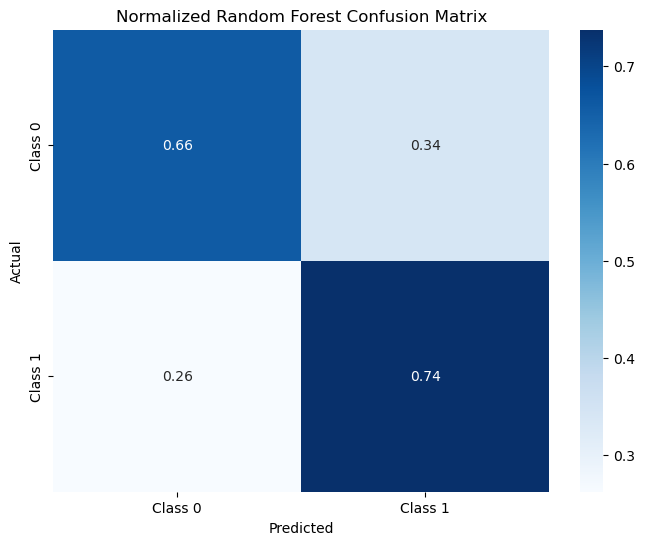

In [672]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Normalize the confusion matrix to get proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Normalized Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [673]:
# Get feature importances from the trained Random Forest model
importances = rf.feature_importances_
# Get the feature names (assuming you have the feature names stored in a variable like 'X_train.columns')
feature_names = X_train.columns
# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head(20)


,Feature,Importance
4,char_F,0.646228
3,char_M,0.281442
129,joy,0.029735
2,plot_length_nb_words,0.027244
0,movie_release_date,0.015351
5,Drama,0.000000
84,Bulgaria,0.000000
97,Luxembourg,0.000000
96,Norway,0.000000
95,Peru,0.000000


## Logistic regression

In [689]:
log_reg_model = LogisticRegression(random_state=42, max_iter=500)

# Fit the model
log_reg_model.fit(X_train_standardized, y_train)

y_pred_test_reg = log_reg_model.predict(X_test_standardized)
y_pred_train_reg = log_reg_model.predict(X_train_standardized)
print(f'The accuracy score for test set is: {accuracy_score(y_test, y_pred_test_reg)}')
print(f'The accuracy score for train set is: {accuracy_score(y_train, y_pred_train_reg)}')


The accuracy score for test set is: 0.7014925373134329
The accuracy score for train set is: 0.7201046337817638


### with feature selection

In [700]:
from sklearn.feature_selection import RFE

selector = RFE(estimator=LogisticRegression(random_state=42, max_iter=500), n_features_to_select=50, step=1)
X_train_selected = selector.fit_transform(X_train_standardized, y_train)
X_test_selected = selector.transform(X_test_standardized)

log_reg_model.fit(X_train_selected, y_train)
y_pred_test_reg = log_reg_model.predict(X_test_selected)
y_pred_train_reg = log_reg_model.predict(X_train_selected)
print(f'The accuracy score for test set is: {accuracy_score(y_test, y_pred_test_reg)}')
print(f'The accuracy score for train set is: {accuracy_score(y_train, y_pred_train_reg)}')

The accuracy score for test set is: 0.7238805970149254
The accuracy score for train set is: 0.7156203288490284


In [703]:
# Get the selected feature names
selected_features = X_train.columns[selector.get_support()]
# selected_features = X_train.columns

# Get the coefficients from the logistic regression model
coefficients = log_reg_model.coef_[0]  # For binary classification

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Display the top 20 features
feature_importance_df.head(20)



,Feature,Coefficient,Importance
2,char_F,1.114280,1.114280
1,char_M,-0.636882,0.636882
10,Feminist,0.433623,0.433623
28,Serbia,-0.288810,0.288810
30,Egypt,0.277519,0.277519
31,Russia,-0.267076,0.267076
33,Norway,-0.244737,0.244737
25,Austria,0.223857,0.223857
37,Iceland,0.212316,0.212316
24,Lebanon,-0.208403,0.208403


# Correlation

In [720]:
correlation_matrix = bechdel_ML[['bechdel_rating', 'char_F', 'char_M', "director_gender", "joy"]].corr()

correlation_matrix


,bechdel_rating,char_F,char_M,director_gender,joy
bechdel_rating,1.000000,0.347983,-0.184439,0.139783,0.100264
char_F,0.347983,1.000000,0.225730,0.091533,0.102969
char_M,-0.184439,0.225730,1.000000,-0.120203,-0.045869
director_gender,0.139783,0.091533,-0.120203,1.000000,0.103442
joy,0.100264,0.102969,-0.045869,0.103442,1.000000


In [721]:
import plotly.graph_objects as go
import plotly.express as px

# Calculate the correlation matrix
correlation_matrix = bechdel_ML[['bechdel_rating', 'char_F', 'char_M', "director_gender", "joy"]].corr()

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,  # The correlation matrix values
    x=correlation_matrix.columns,  # Column names for the x-axis
    y=correlation_matrix.columns,  # Column names for the y-axis
    colorscale='Viridis',  # Choose a color scale for better visual representation
    zmin=-1,  # Minimum correlation value
    zmax=1,  # Maximum correlation value
    colorbar=dict(title="Correlation Coefficient")  # Add color bar
))

# Update the layout for better readability
fig.update_layout(
    title="Correlation Matrix of Selected Features",
    xaxis_title="Features",
    yaxis_title="Features",
    autosize=True,
    template="plotly_dark"  # Optional: Choose a theme
)

# Show the plot
fig.show()


# Bechdel further analysis

In [732]:
bechdel_complete = bechdel_complete.drop(columns=["actor_genders", "movie_genres", "movie_countries", "actor_genders", "emotion_scores", "dominant_emotion", "plot_length_nb_words"])

In [734]:
bechdel_complete = bechdel_complete[["wikipedia_movie_id", "movie_name", "movie_release_date", "director_gender", "char_M", "char_F", "neutral", "sadness", "anger", "fear", "disgust", "surprise", "joy"]]

In [735]:
bechdel_complete

,wikipedia_movie_id,movie_name,movie_release_date,director_gender,char_M,char_F,neutral,sadness,anger,fear,disgust,surprise,joy
0,171005,Henry V,1989,0,18,3,0.679410,0.057925,0.016094,0.003841,0.004746,0.129912,0.108072
1,77856,Mary Poppins,1964,0,7,6,0.138584,0.243435,0.218646,0.063908,0.036475,0.090769,0.208183
2,12053509,Loverboy,1989,1,8,6,0.150340,0.231786,0.221961,0.148329,0.123119,0.043714,0.080752
3,1369204,Juarez,1939,0,3,1,0.103526,0.200089,0.308751,0.257346,0.044936,0.080762,0.004589
4,5664529,Vixen!,1968,0,4,1,0.171327,0.050615,0.464636,0.003769,0.081863,0.003471,0.224319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,303933,Twister,1996,1,12,5,0.345438,0.140309,0.132143,0.199097,0.043645,0.030557,0.108812
3342,25920477,Source Code,2011,0,13,4,0.454169,0.054210,0.090608,0.069313,0.153779,0.170574,0.007347
3343,1191380,Wilde,1997,0,6,5,0.246951,0.044272,0.088300,0.012097,0.416067,0.004161,0.188152
3344,54540,Coming to America,1988,0,15,6,0.199333,0.211627,0.325282,0.004143,0.063889,0.165895,0.029831


In [738]:
bechdel_complete.apply(lambda x: 0 if x["char_F"] < x["char_M"] else 1, axis=1).value_counts()

0    2596
1     750
Name: count, dtype: int64

In [740]:
bechdel_complete["more_F"] = bechdel_complete.apply(lambda x: 0 if x["char_F"] < x["char_M"] else 1, axis=1).value_counts()

In [741]:
bechdel_complete.groupby(["director_gender", "more_F"])[["neutral", "sadness", "anger", "fear", "disgust", "surprise", "joy"]].mean()

neutral   sadness     anger      fear   disgust  \
director_gender more_F                                                     
0               750.0   0.138584  0.243435  0.218646  0.063908  0.036475   
                2596.0  0.679410  0.057925  0.016094  0.003841  0.004746   

                        surprise       joy  
director_gender more_F                      
0               750.0   0.090769  0.208183  
                2596.0  0.129912  0.108072